# IMPORTS

In [1]:
import tensorflow_datasets as tfds
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
from google.colab import drive
import tensorflow as tf
from google.colab import runtime
from transformers import ViTForImageClassification
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOADING DATA

In [3]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [4]:
TfDatasetsPath = '/content/drive/MyDrive/CSEN-240-Project/TfDatasets'
# TfDatasetsPath = 'TfDatasets'

In [5]:
trainDataset = tf.data.Dataset.load(TfDatasetsPath + "/trainDataset")
validDataset = tf.data.Dataset.load(TfDatasetsPath + "/validDataset")
testDataset = tf.data.Dataset.load(TfDatasetsPath + "/testDataset")

In [6]:
def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_flip_up_down(image)
    image - tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

In [7]:
augmentedDataset = trainDataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
trainDataset = trainDataset.concatenate(augmentedDataset)

augmentedDataset = trainDataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
trainDataset = trainDataset.concatenate(augmentedDataset)

In [8]:

class TFDSDataset(Dataset):
    def __init__(self, tf_dataset, transform=None):
        self.tf_dataset = list(tf_dataset)  # Convert TF dataset to a list
        self.transform = transform

    def __len__(self):
        return len(self.tf_dataset)

    def __getitem__(self, idx):
        image, label = self.tf_dataset[idx]

        # Convert TensorFlow tensor to NumPy array and ensure it's in the correct format for PIL
        image = image.numpy()

        # Ensure image is in HWC (Height, Width, Channels) format
        if image.ndim == 3 and image.shape[0] == 1:  # If the image is in (1, H, W, C) or similar
            image = np.squeeze(image, axis=0)  # Remove the first singleton dimension

        # Convert float images to uint8
        if image.dtype == np.float32:
            image = np.clip(image * 255, 0, 255).astype(np.uint8)  # Scale float32 to uint8

        # Convert numpy array to PIL image
        image = Image.fromarray(image)

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label.numpy()

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to range (-1, 1) as ViT expects
])

In [10]:
trainDataset = TFDSDataset(trainDataset, transform=transform)
validDataset = TFDSDataset(validDataset, transform=transform)
testDataset = TFDSDataset(testDataset, transform=transform)

In [11]:
trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
validLoader = DataLoader(validDataset, batch_size=batch_size, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

# ViT-Base16 Model

In [12]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=3, ignore_mismatched_sizes=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

# TRAINING

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=250, early_stopping_patience=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Lists to store training history
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # outputs is an ImageClassifierOutput object
            logits = outputs.logits  # Access the logits from the output object

            # Ensure labels are in the correct format (not one-hot encoded)
            if len(labels.shape) > 1:  # If labels are one-hot encoded
                labels = labels.argmax(dim=1)

            loss = criterion(logits, labels)  # Use logits for loss calculation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = logits.max(1)  # Get predicted class indices
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Validation Loop
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                logits = outputs.logits  # Extract logits

                # Ensure labels are in the correct format (not one-hot encoded)
                if len(labels.shape) > 1:  # If labels are one-hot encoded
                    labels = labels.argmax(dim=1)

                loss = criterion(logits, labels)
                val_loss += loss.item()

                _, predicted = logits.max(1)  # Get predicted class indices
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        # Compute epoch-wise losses and accuracies
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = correct_train / total_train
        val_acc = correct_val / total_val

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} - Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Update LR Scheduler
        scheduler.step(avg_val_loss)

        for param_group in optimizer.param_groups:
            print(f"Epoch [{epoch+1}/{num_epochs}] - LR: {param_group['lr']:.6f}")

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_vit_model.pth")  # Save best model
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered. Training stopped.")
            break

    # Return Training History
    return train_losses, val_losses, train_accuracies, val_accuracies

In [14]:
for param in model.vit.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, trainLoader, validLoader, criterion, optimizer, scheduler, num_epochs=250, early_stopping_patience=8)

Epoch [1/250] - Train Loss: 0.8559, Train Acc: 0.6090 - Val Loss: 0.7854, Val Acc: 0.6534
Epoch [2/250] - Train Loss: 0.7511, Train Acc: 0.6648 - Val Loss: 0.7650, Val Acc: 0.6481
Epoch [3/250] - Train Loss: 0.7193, Train Acc: 0.6801 - Val Loss: 0.7580, Val Acc: 0.6455
Epoch [4/250] - Train Loss: 0.7009, Train Acc: 0.6901 - Val Loss: 0.7396, Val Acc: 0.6376
Epoch [5/250] - Train Loss: 0.6864, Train Acc: 0.6921 - Val Loss: 0.7227, Val Acc: 0.6614
Epoch [6/250] - Train Loss: 0.6737, Train Acc: 0.7023 - Val Loss: 0.7241, Val Acc: 0.6799
Epoch [7/250] - Train Loss: 0.6649, Train Acc: 0.7067 - Val Loss: 0.7128, Val Acc: 0.6587
Epoch [8/250] - Train Loss: 0.6555, Train Acc: 0.7081 - Val Loss: 0.7080, Val Acc: 0.6534
Epoch [9/250] - Train Loss: 0.6507, Train Acc: 0.7144 - Val Loss: 0.7228, Val Acc: 0.6667
Epoch [10/250] - Train Loss: 0.6401, Train Acc: 0.7184 - Val Loss: 0.7069, Val Acc: 0.6905
Epoch [11/250] - Train Loss: 0.6357, Train Acc: 0.7226 - Val Loss: 0.7297, Val Acc: 0.6772
Epoch [1

# FINE-TUNING

In [33]:
for param in model.vit.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
train_losses_finetune, val_losses_finetune, train_accuracies_finetune, val_accuracies_finetune = train_model(
    model, trainLoader, validLoader, criterion, optimizer, scheduler, num_epochs=250, early_stopping_patience=8
)

Epoch [1/250] - Train Loss: 0.0616, Train Acc: 0.9750 - Val Loss: 0.9294, Val Acc: 0.7910
Epoch [2/250] - Train Loss: 0.0553, Train Acc: 0.9762 - Val Loss: 0.9837, Val Acc: 0.7672
Epoch [3/250] - Train Loss: 0.0539, Train Acc: 0.9759 - Val Loss: 0.9031, Val Acc: 0.7566
Epoch [4/250] - Train Loss: 0.0439, Train Acc: 0.9802 - Val Loss: 1.0720, Val Acc: 0.7751
Epoch [5/250] - Train Loss: 0.0435, Train Acc: 0.9798 - Val Loss: 1.0146, Val Acc: 0.7857
Epoch [6/250] - Train Loss: 0.0431, Train Acc: 0.9783 - Val Loss: 1.0914, Val Acc: 0.7989
Epoch [7/250] - Train Loss: 0.0418, Train Acc: 0.9799 - Val Loss: 1.1349, Val Acc: 0.7857
Epoch [8/250] - Train Loss: 0.0554, Train Acc: 0.9746 - Val Loss: 0.9762, Val Acc: 0.7487
Epoch [9/250] - Train Loss: 0.0362, Train Acc: 0.9817 - Val Loss: 0.9937, Val Acc: 0.7778
Epoch [10/250] - Train Loss: 0.0352, Train Acc: 0.9828 - Val Loss: 1.0787, Val Acc: 0.7857
Epoch [11/250] - Train Loss: 0.0340, Train Acc: 0.9830 - Val Loss: 1.0481, Val Acc: 0.7751
Early st

# PLOTS

In [16]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.show()

## Pre-Trained

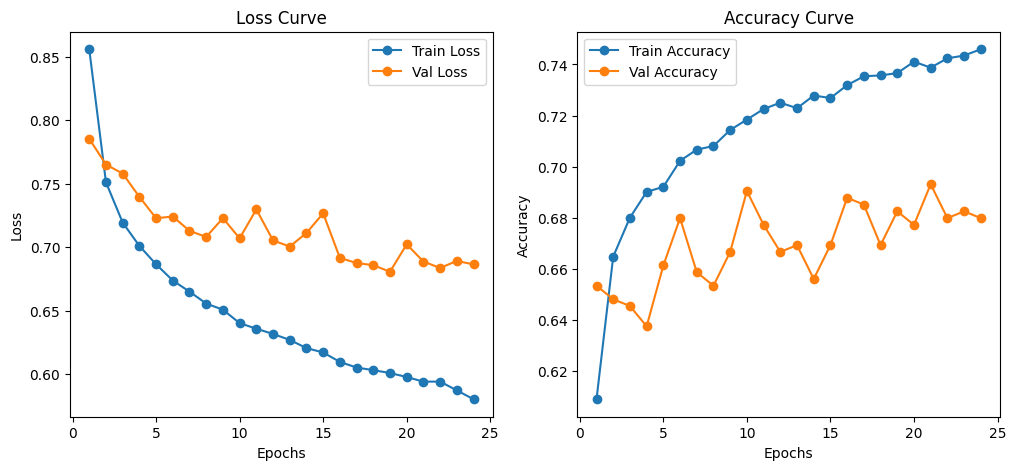

In [17]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

## Fine-Tuned

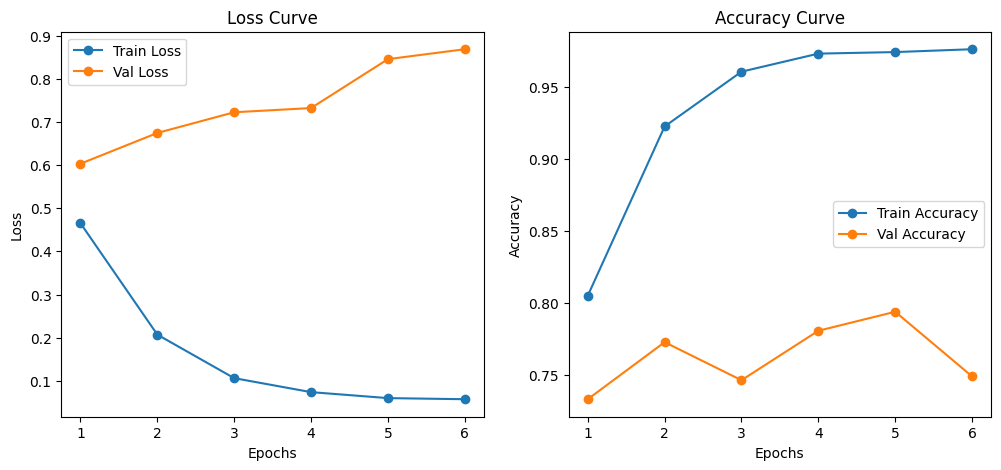

In [18]:
plot_metrics(train_losses_finetune, val_losses_finetune, train_accuracies_finetune, val_accuracies_finetune)

# TESTING

In [21]:
def evaluate_model(model, test_loader, categories):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            _, predicted = outputs.max(1)  # Get the predicted class indices

            # If labels are one-hot encoded, convert them to class indices
            if len(labels.shape) > 1:
                labels = labels.argmax(dim=1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print Classification Report
    print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=categories))

In [23]:
evaluate_model(model, testLoader, categories)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.82      0.86      0.84       126
  Osteopenia       0.77      0.81      0.79       126
Osteoporosis       0.83      0.75      0.79       126

    accuracy                           0.81       378
   macro avg       0.81      0.81      0.81       378
weighted avg       0.81      0.81      0.81       378



# PR CURVE

In [34]:
def find_best_thresholds(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.cpu().numpy()  # Keep labels on CPU for ease of use

            # Get the model's raw output logits
            outputs = model(images).logits

            # Apply sigmoid to convert logits to probabilities (for multi-label classification)
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)

            all_probs.append(probs)
            all_labels.append(labels)

    all_probs = np.vstack(all_probs)  # Stack all the probabilities together (shape: [n_samples, n_classes])
    all_labels = np.concatenate(all_labels)  # Concatenate all the labels together (shape: [n_samples, n_classes])

    num_classes = all_probs.shape[1]  # Number of classes
    best_thresholds = []

    # Iterate over each class to compute thresholds
    for class_idx in range(num_classes):
        # Get binary labels for the current class (0 or 1 for each sample)
        binary_labels = all_labels[:, class_idx]  # Directly use the labels for multi-label

        # Compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(binary_labels, all_probs[:, class_idx])

        # Calculate F1 score for each threshold
        f1_scores = (2 * precision * recall) / (precision + recall + 1e-6)  # Avoid division by zero

        # Find the threshold with the maximum F1 score
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_thresholds.append(best_threshold)

        print(f"Best threshold for class {class_idx}: {best_threshold:.4f}")

    return best_thresholds


best_thresholds = find_best_thresholds(model, testLoader)
best_thresholds

Best threshold for class 0: 0.8653
Best threshold for class 1: 0.8958
Best threshold for class 2: 0.7240


[0.86532235, 0.89583576, 0.72401744]

In [35]:
def evaluate_with_best_thresholds(model, test_loader, best_thresholds):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.cpu().numpy()

            outputs = model(images).logits

            # Apply sigmoid to get probabilities for each class
            probs = torch.sigmoid(outputs).cpu().numpy()

            # Apply best thresholds for each class to get multi-label predictions
            preds = np.zeros_like(probs)
            for class_idx in range(len(best_thresholds)):
                preds[:, class_idx] = probs[:, class_idx] > best_thresholds[class_idx]

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Convert lists of predictions and labels into numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Print Classification Report
    print("Classification Report with Optimized Thresholds:\n", classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1", "Class 2"]))


In [36]:
# Evaluate with best thresholds
evaluate_with_best_thresholds(model, testLoader, best_thresholds)

Classification Report with Optimized Thresholds:
               precision    recall  f1-score   support

     Class 0       0.82      0.85      0.83       126
     Class 1       0.80      0.78      0.79       126
     Class 2       0.72      0.89      0.80       126

   micro avg       0.78      0.84      0.81       378
   macro avg       0.78      0.84      0.81       378
weighted avg       0.78      0.84      0.81       378
 samples avg       0.77      0.84      0.79       378



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
runtime.unassign()